In [198]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

## Load Data

In [45]:
# load data
data = pd.read_csv("./all/train_2.csv")

In [46]:
whole_period = len(data.columns) -1
print("dates are amount to {}, from {} to {}".format(whole_period, data.columns[1],data.columns[-1]))

dates are amount to 803, from 2015-07-01 to 2017-09-10


## Train Test Split
1. whether need data augmentation or cross validation by overlapping train data ?
2. whether avoid wasting testing encoder data points by overlapping train and test data ?

In [47]:
train_window = 365
predict_shift = 30
predict_window = 365
test_start = whole_period - predict_window - predict_shift # start point for test training and predicting
overlap = 0        # overlap shows overlap between train and test
split_point = test_start + overlap # data before split_point cound be used for train and validation

def train_test_split(aug_shift = []):
    test_X = data[list(data.columns[1+test_start:test_start + train_window])]
    test_Y = data[list(data.columns[1+test_start + predict_shift:test_start + predict_shift + predict_window])]
    train_X = data[list(data.columns[1:train_window])]
    train_Y = data[list(data.columns[1+predict_shift:predict_shift + predict_window])]
    if(len(aug_shift)): #data_augmentation
        for aug in aug_shift:
            aug_X,aug_Y = augmentation(aug)
            train_X = pd.concat([train_X,aug_X])
            train_Y = pd.concat([train_Y,aug_Y])
    val_X, val_Y = augmentation(split_point - predict_window - predict_shift)
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

def augmentation(aug_shift):
    X = data[list(data.columns[aug_shift:aug_shift + train_window])]
    Y = data[list(data.columns[aug_shift + predict_shift:aug_shift + predict_shift + predict_window])]
    return X,Y

In [48]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = train_test_split()

## Data Preprocessing
1. normalize(values - means), regard means as additional feature
2. map to bins(std), regard std as additional feature
3. missing values: set to -1
4. batchify

In [142]:
df = train_X[:200]
df = df.dropna(how="all")

In [176]:
mean_df = df.mean(axis= 1,skipna=True)
std_df = df.std(axis = 1,skipna=True)
index = df.divide(0.05*std_df,axis=0).fillna(-1).astype(int).values

(184, 364)

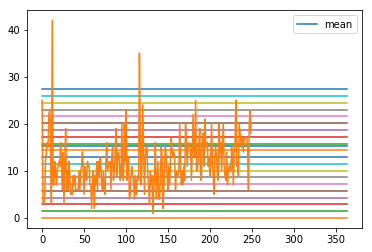

In [148]:
idx = 20
val = df.iloc[idx].values
plt.plot([mean_df.iloc[idx]]*len(val),label = "mean")
#plt.plot([0.2*std_df.iloc[0]]*len(val),label = "std")
for d in np.arange(0,1,0.05):
    plt.plot([d*std_df.iloc[idx]]*len(val))
plt.plot(val[:250])
plt.legend()
plt.show()

In [178]:
mean_df.values.shape

(184,)

In [130]:
len(np.arange(0,20,0.05))

400

In [195]:
def X_loader(df,std_ratio = 0.05,batchsize=10):
    df = df.dropna(how="all").reset_index()
    mean_df = df.mean(axis= 1,skipna=True)
    std_df = df.std(axis = 1,skipna=True)
    x = df.divide(std_ratio*std_df,axis=0).fillna(-1).astype(int).values
    batch=0
    while batch<(len(x) // batchsize):
        data=x[batch*batchsize:(batch+1)*batchsize,:]
        mean=mean_df.values[batch*batchsize:(batch+1)*batchsize]
        std = std_df.values[batch*batchsize:(batch+1)*batchsize]
        #yield(torch.LongTensor(data),torch.Tensor(mean),torch.Tensor(std).cuda())
        yield(torch.LongTensor(data),torch.Tensor(mean),torch.Tensor(std))
        batch+=1
def Y_loader(df, batchsize=10):
    df = df.dropna(how="all").reset_index()
    y = df.fillna(-1).values
    batch=0
    while batch<(len(y) // batchsize):
        data=y[batch*batchsize:(batch+1)*batchsize,:]
        #yield(torch.FloatTensor(data).cuda())
        yield(torch.Tensor(data))
        batch+=1

In [196]:
xloader = X_loader(df)
for data,mean,std in xloader:
    print(data)
    print(mean)
    break
yloader = Y_loader(df)
for data in yloader:
    print(data)
    break


    0    10     6  ...     41     6    10
    1    11    14  ...     13    14    24
    3     1     0  ...      1     9     8
       ...          ⋱          ...       
    7     4    20  ...     37    25    36
   19    12     6  ...     57    44    66
    9    -1    -1  ...    102    75    32
[torch.LongTensor of size 10x365]


 20.5534
 21.3315
  4.9945
 17.0658
 11.4459
 13.5123
 39.3452
 33.3781
 20.0740
 12.7635
[torch.FloatTensor of size 10]


    0    18    11  ...     69    11    18
    1    11    14  ...     13    14    24
    2     1     0  ...      1     6     5
       ...          ⋱          ...       
    8     5    23  ...     42    28    40
    9     6     3  ...     27    21    31
   10    -1    -1  ...    109    81    35
[torch.FloatTensor of size 10x365]



In [197]:
train_Xloader = X_loader(train_X)
train_Yloader = Y_loader(train_Y)

## Build Model

In [199]:
class AutoEncoder(nn.Module):
    def __init__(self, emb_dim,encoder_dim=150,out_dim=63, vocab_size=1200):
        super(NN, self).__init__()

        self.emb_dim = emb_dim
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.encoder = nn.GRU(emb_dim, encoder_dim, batch_first=True, bidirectional=False)
        self.decoder = nn.Linear(encoder_dim, out_dim)
    def forward(self, x):

        out = self.embed(x) 
#         print('embedding',out)
        output, hidden = self.encoder(out)
#         print('hidden',hidden)
        output = self.decoder(hidden)
        return output.squeeze()

## Train